In [72]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting Sensory data

- We are using data from Garmin watch. 
- For this assignment running activities were observed, specifically tempo and recovery runs. 
- 4 runs were extracted: 12km tempo, 10km tempo, 10km recovery, 8km recovery. In total, ~4h of data. Each run activity is labeled according to its type and distance.
- **Features:** 
    - Time
    - Distance
    - Altitude
    - Cadence
    - HeartRate
    - Speed
- **Engineered features (TBD):**
    - Pace (Time/Distance)
    - Elevation Gain (to be calculated)
    - Cadence per minute (In current dataset cadence metric is really akward and hardly understandable. Usually, cadence measures frequency of steps (for both feet) per minute. Moreover, in this dataset cadence corresponds to frequency of steps only for one foot, so it should be multiplied by 2)

In [73]:
def parse_tcx(tcx_file):
    tree = ET.parse(tcx_file)
    root = tree.getroot()

    data = []
    
    for activity in root.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities'):
        for lap in activity.findall('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Lap'):
            for track in lap.findall('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Track'):
                for trackpoint in track.findall('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Trackpoint'):
                    # Extract time, distance, and heart rate data
                    time_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time')
                    distance_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters')
                    heart_rate_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}HeartRateBpm/{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Value')
                    speed_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Extensions/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}TPX/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}Speed')
                    run_cadence_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Extensions/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}TPX/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}RunCadence')
                    altitude_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}AltitudeMeters')
                    
                    if time_element is not None and distance_element is not None and heart_rate_element is not None and run_cadence_element is not None and speed_element is not None:
                        data.append({
                            'Time': time_element.text,
                            'Distance': float(distance_element.text),
                            'Altitude': float(altitude_element.text),
                            'HeartRate': int(heart_rate_element.text),
                            'Speed': float(speed_element.text),
                            'Cadence': int(run_cadence_element.text)
                        })

    return data

def heart_rate_zone(heart_rate):
    # Define your own heart rate zones here
    if heart_rate <= 141:
        return 'Zone 1'
    elif heart_rate >= 142 and heart_rate <= 157:
        return 'Zone 2'
    elif heart_rate >= 158 and heart_rate <= 167:
        return 'Zone 3'
    elif heart_rate >= 168 and heart_rate <= 174:
        return 'Zone 4'
    elif heart_rate > 174:
        return 'Zone 5'


# # Calculate pace (time per km) - note this is a simple calculation and may not be accurate
# def calculate_pace(df):
#     df['Time'] = pd.to_datetime(df['Time'])
#     timeDiff = df['Time'].diff()
#     distanceDiff = df['Distance'].diff()
#     df['Pace'] = timeDiff.dt.total_seconds() / distanceDiff
    

#Activity labels. Currently not used
labels = ['recovery','tempo']

In [74]:
tcx_files = ['10km_tempo.tcx', '12km_tempo.tcx', '8km_recovery.tcx', '10km_recovery.tcx']

dataframes = []

for file in tcx_files:
    # Parse the TCX file to a DataFrame
    data = parse_tcx('data/'+ file)
    df = pd.DataFrame(data)
    #calculate_pace(df)
    df['HeartRateZone'] = df['HeartRate'].apply(heart_rate_zone)
    df['Run'] = os.path.splitext(file)[0]  # extracts "10km_tempo", "12km_tempo", etc. from file names

    # Append the DataFrame to the list
    dataframes.append(df)
# Concatenate all dataframes
all_runs_df = pd.concat(dataframes, ignore_index=True)
all_runs_df.to_csv('running_data.csv')

## Initial exploratory Data Analysis

In [75]:
data = pd.read_csv('running_data.csv', delimiter = ',')

print(data)

       Unnamed: 0                      Time      Distance    Altitude  \
0               0  2022-07-29T05:21:40.000Z      1.200000  325.600006   
1               1  2022-07-29T05:21:41.000Z      3.670000  325.600006   
2               2  2022-07-29T05:21:42.000Z      6.070000  325.600006   
3               3  2022-07-29T05:21:43.000Z      7.870000  325.600006   
4               4  2022-07-29T05:21:44.000Z     10.080000  325.600006   
...           ...                       ...           ...         ...   
15113       15113  2022-09-06T06:00:59.000Z  10003.740234   -1.000000   
15114       15114  2022-09-06T06:00:59.000Z  10003.740234   -1.000000   
15115       15115  2022-09-06T06:01:00.000Z  10006.309570   -0.800000   
15116       15116  2022-09-06T06:01:01.000Z  10010.650391   -0.800000   
15117       15117  2022-09-06T06:01:02.000Z  10010.650391   -0.800000   

       HeartRate  Speed  Cadence HeartRateZone            Run  
0             92  0.000       83        Zone 1     10km_tem

In [76]:
#fixing Cadence to be for both feet
data['Cadence'] = data['Cadence'] * 2

### Helper functions

In [77]:
def count_missing_values(df):
    missing_values = df.isnull().sum()
    print("Missing values per column:")
    for column, count in missing_values.iteritems():
        print(f"{column}: {count}")

def plot_column(df, column_name):
    # plt.plot(df[column_name])
    plt.scatter(df.index, df[column_name], marker='o', s=5)
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.title(f'Plot of {column_name}')
    plt.show()

def plot_column_per_run(data, column_name):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    # Iterate over each run type and plot the feature in the corresponding subplot
    for i, run_type in enumerate(data['Run'].unique()):
        ax = axes[i // 2, i % 2]  # Get the appropriate subplot
        subset = data[data['Run'] == run_type]  # Filter the data for the specific run type
        
        # Plot the feature for the run type
        ax.plot(subset[column_name])
        ax.set_title(f'{column_name} {run_type}')  # Set the subplot title
        

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

### Analysis the for whole dataset

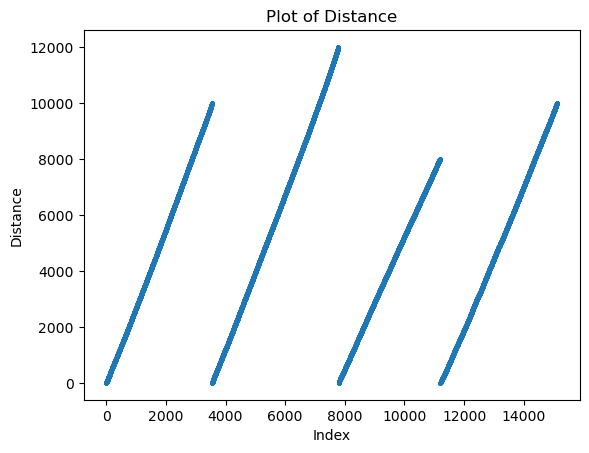

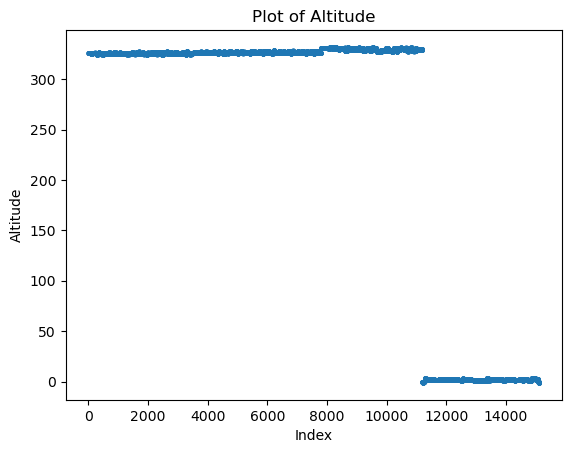

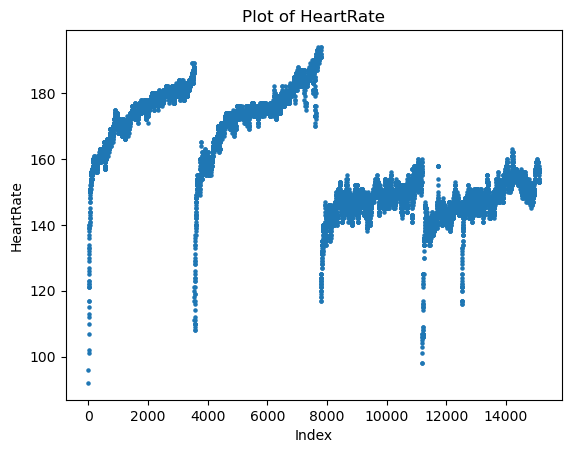

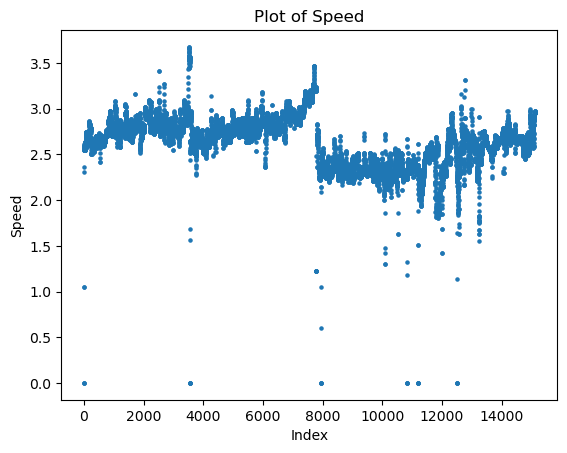

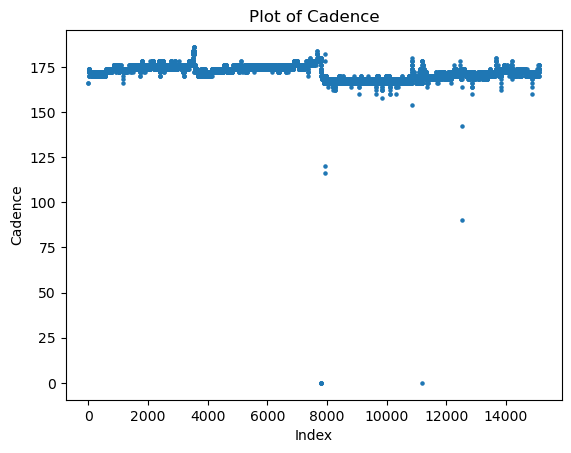

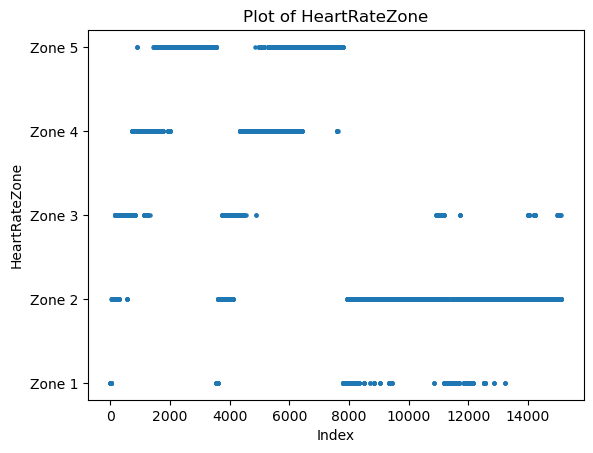

In [78]:
plot_column(data, 'Distance')
plot_column(data, 'Altitude')
plot_column(data, 'HeartRate')
plot_column(data, 'Speed')
plot_column(data, 'Cadence')
plot_column(data, 'HeartRateZone')


### Distribution of features per each run

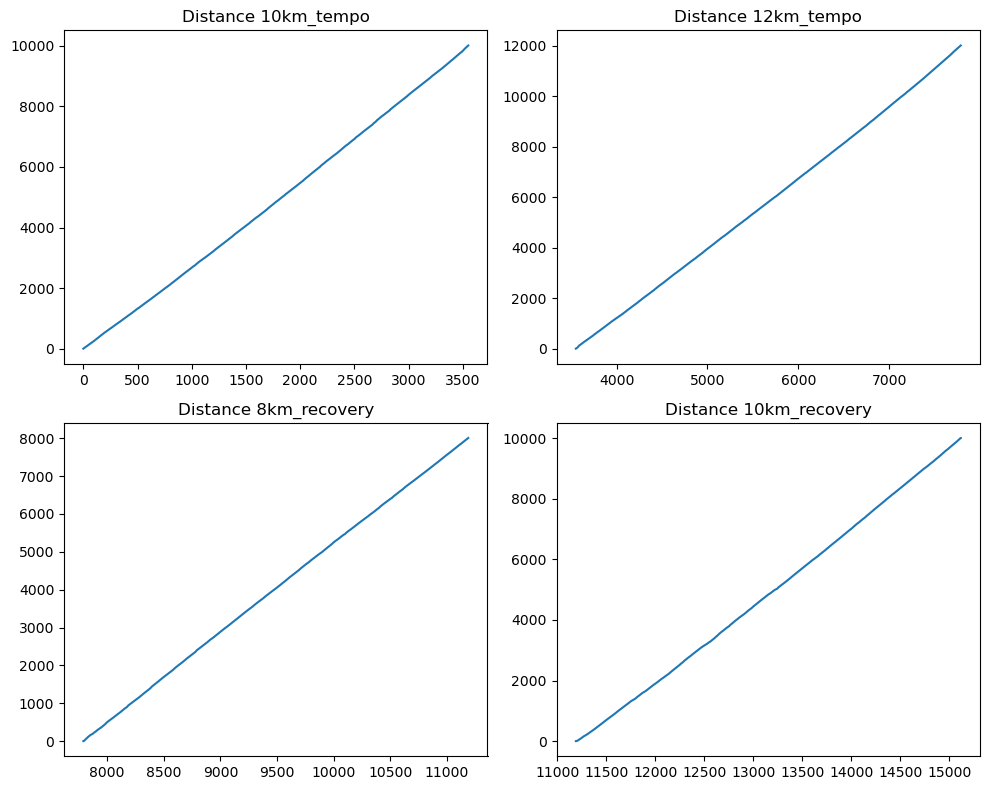

In [79]:
plot_column_per_run(data, 'Distance')

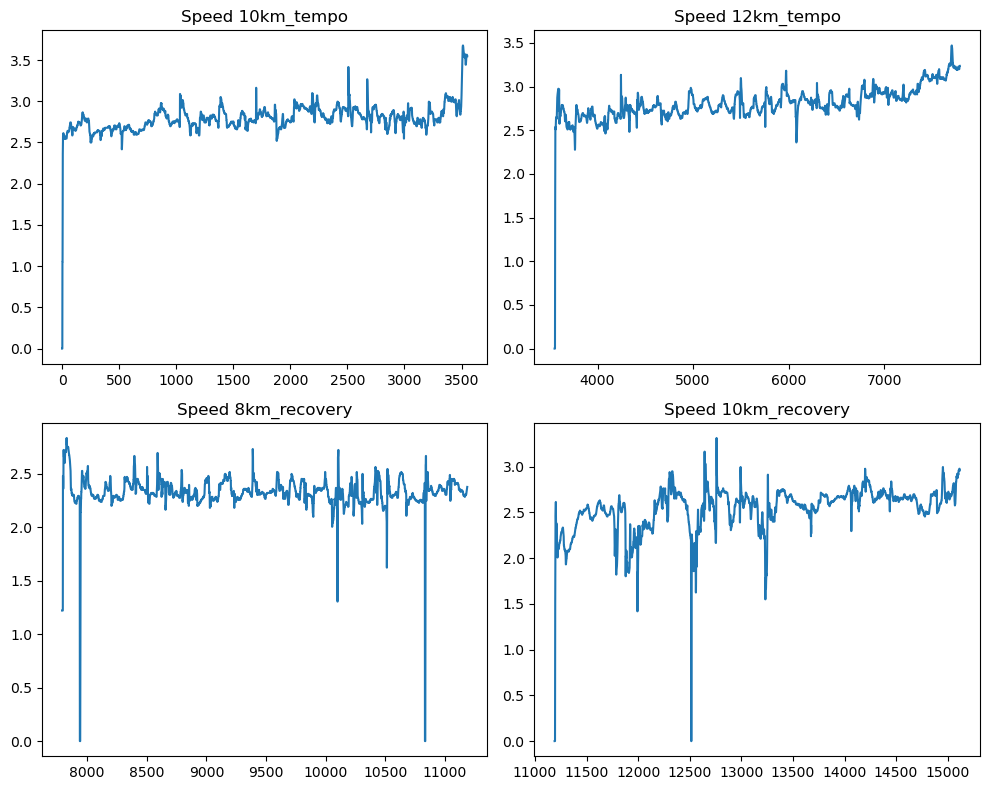

In [80]:
plot_column_per_run(data, 'Speed')

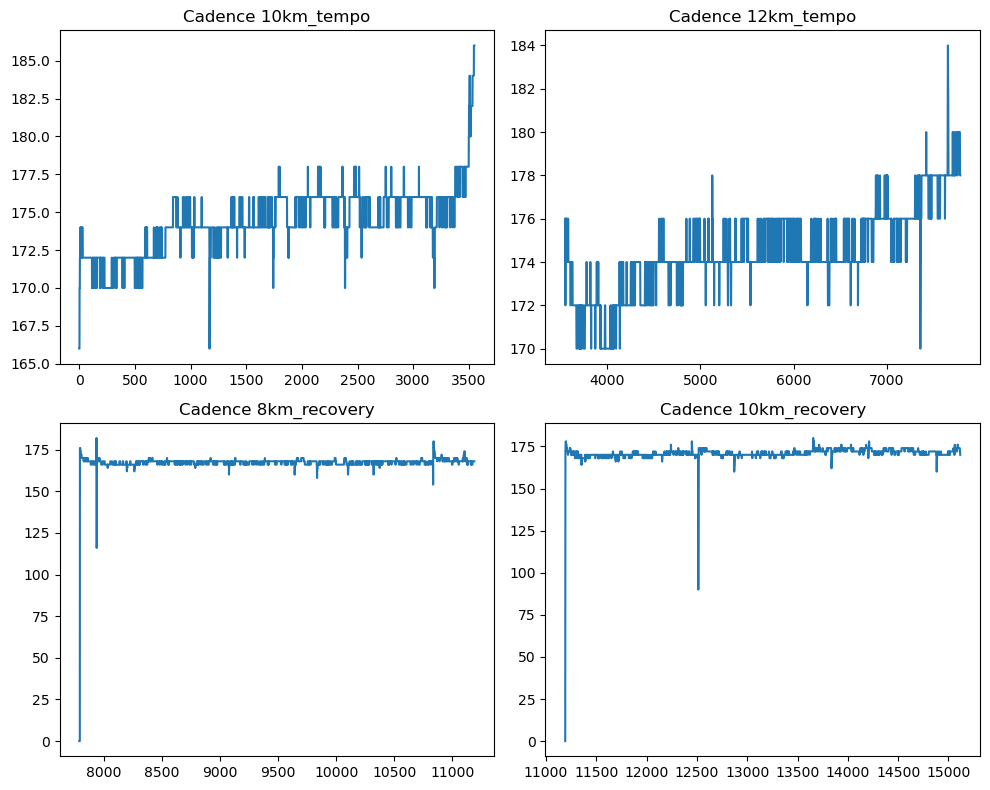

In [81]:
plot_column_per_run(data, 'Cadence')

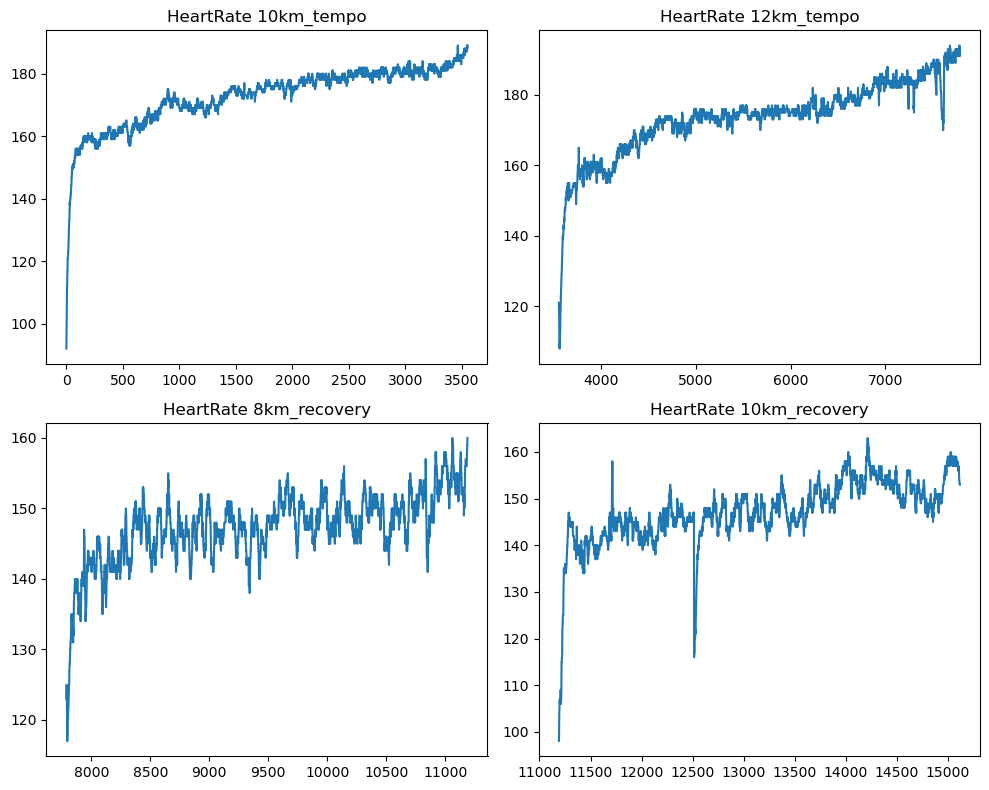

In [82]:
plot_column_per_run(data, 'HeartRate')

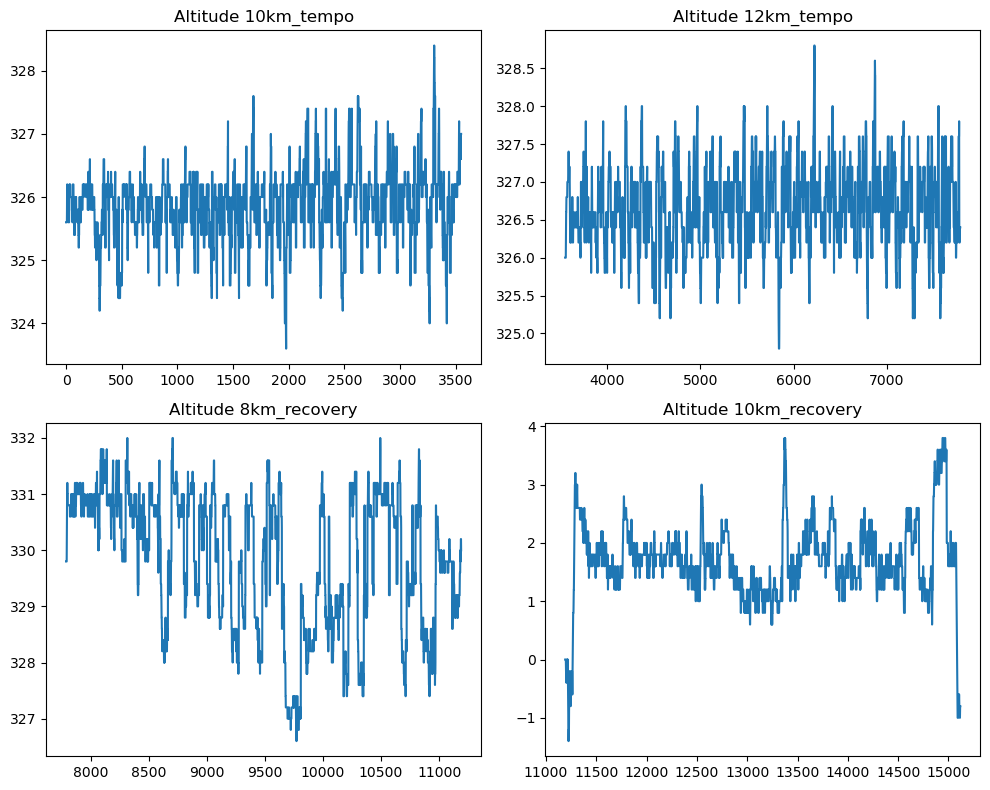

In [83]:
plot_column_per_run(data, 'Altitude')

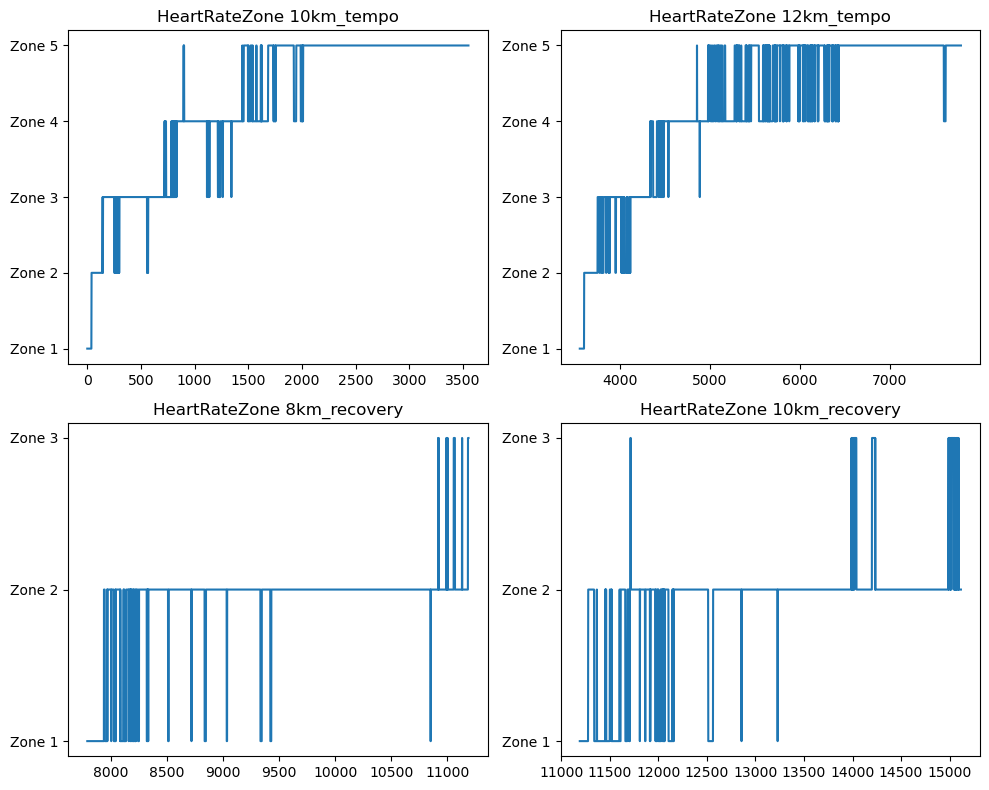

In [84]:
plot_column_per_run(data, 'HeartRateZone')

### Removing outliers

### Heart rate

In [85]:
data['HeartRate'] = data['HeartRate'].astype(float)

last_value = data['HeartRate'].iloc[0]
last_run = data['Run'].iloc[0]
for index, row in data.iterrows():
    current_value = row['HeartRate']
    current_run = row['Run']
    if(last_run == current_run) and ((current_value - last_value) > 7 or (last_value - current_value) > 7):
        # Remove the current value
        # df_D_clean.drop(index, inplace=True)
        data.at[index, 'HeartRate'] = np.nan
        #print('drop')
    else:
        last_value = current_value
        last_run = current_run


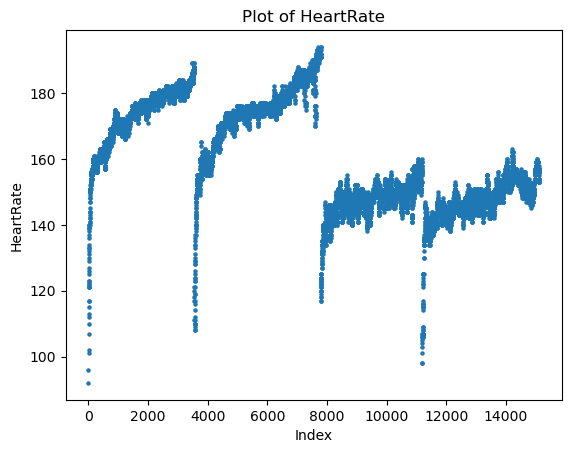

In [86]:
plot_column(data, 'HeartRate')

### Cadence

In [87]:
data['Cadence'] = data['Cadence'].astype(float)

for index, row in data.iterrows():
    current_value = row['Cadence']
    if(last_run == current_run) and current_value < 150: # trial and eror, not based on min or max possible. Hold back with removing to much because could be ciritical information
        data.at[index, 'Cadence'] = np.nan
    else:
        last_run = current_run

num_nan = data['Cadence'].isna().sum()
print(f"Number of NaN values in 'cadence': {num_nan}")

Number of NaN values in 'cadence': 10


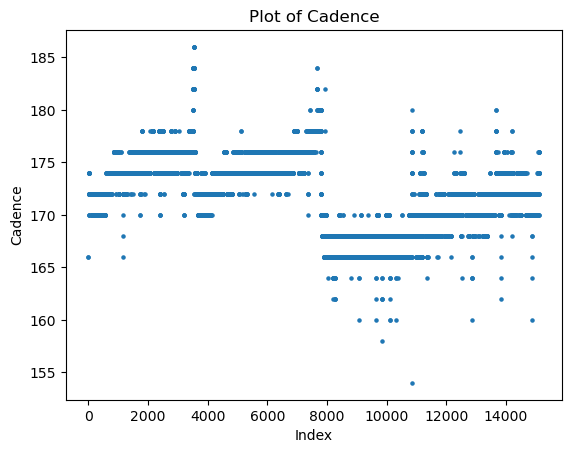

In [88]:
plot_column(data, 'Cadence')

### Speed

In [89]:
data['Speed'] = data['Speed'].astype(float)

last_value = data['Speed'].iloc[0]
last_run = data['Run'].iloc[0]
for index, row in data.iterrows():
    current_value = row['Speed']
    current_run = row['Run']
    if(last_run == current_run) and ((current_value - last_value) > 2 or (last_value - current_value) > 2):  # while jogging may have acceleration values around 1-2 m/s². choose the max to not remove citical values
        data.at[index, 'Speed'] = np.nan
    else:
        last_value = current_value
        last_run = current_run

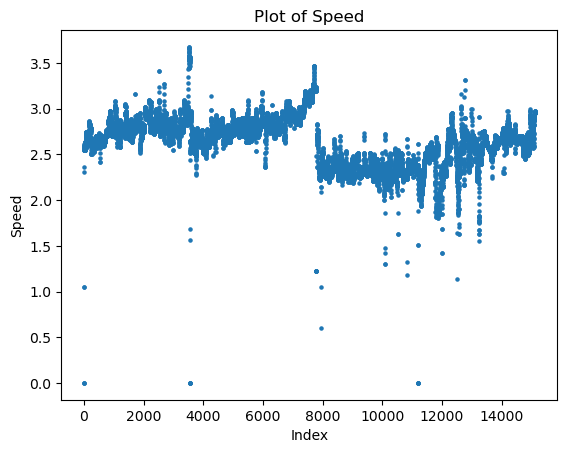

In [90]:
plot_column(data, 'Speed')

### Altitude

In [91]:
data['Altitude'] = data['Altitude'].astype(float)

last_value = data['Altitude'].iloc[0]
last_run = data['Run'].iloc[0]
for index, row in data.iterrows():
    current_value = row['Altitude']
    current_run = row['Run']
    if(last_run == current_run) and ((current_value - last_value) > 1 or (last_value - current_value) > 1): # was found to max change 0.55 within 1 sec. Does remove a lot but this could be explained by noise. Will be fixed with value imputation with neighbouring method
        data.at[index, 'Altitude'] = np.nan
    else:
        last_value = current_value
        last_run = current_run

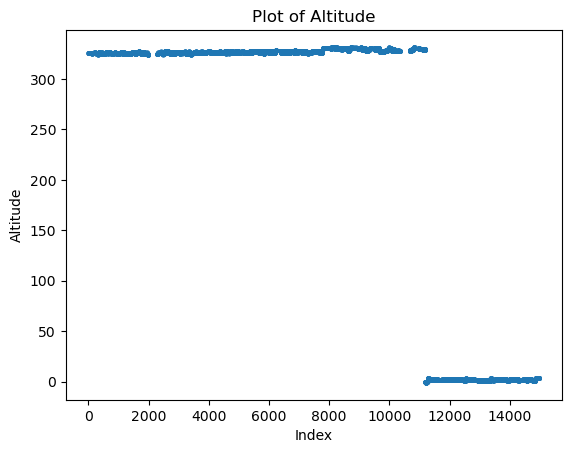

In [92]:
plot_column(data, 'Altitude')

In [93]:
count_missing_values(data)

Missing values per column:
Unnamed: 0: 0
Time: 0
Distance: 0
Altitude: 2757
HeartRate: 51
Speed: 12
Cadence: 10
HeartRateZone: 0
Run: 0


/var/folders/l0/924kw60548b_9q6yvy_gzsyc0000gn/T/ipykernel_8355/1562971855.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, count in missing_values.iteritems():


## Imputing missing values

### Heart Rate

In [94]:
data['HeartRate'] = data['HeartRate'].interpolate(method='polynomial', order=3)

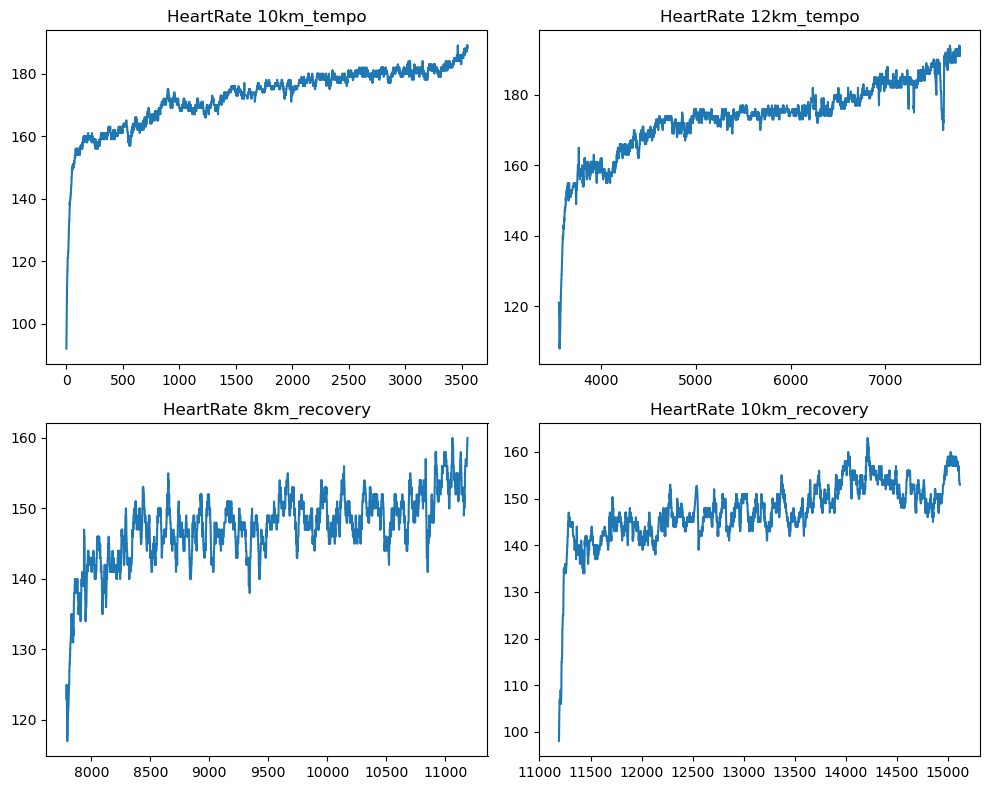

In [95]:
## Using interpolation
plot_column_per_run(data, 'HeartRate')

### Cadence

In [96]:
## Backward fill
# data['Cadence'] = df['Cadence'].fillna(method='bfill')
## Interpolation
data['Cadence'] = data['Cadence'].interpolate()


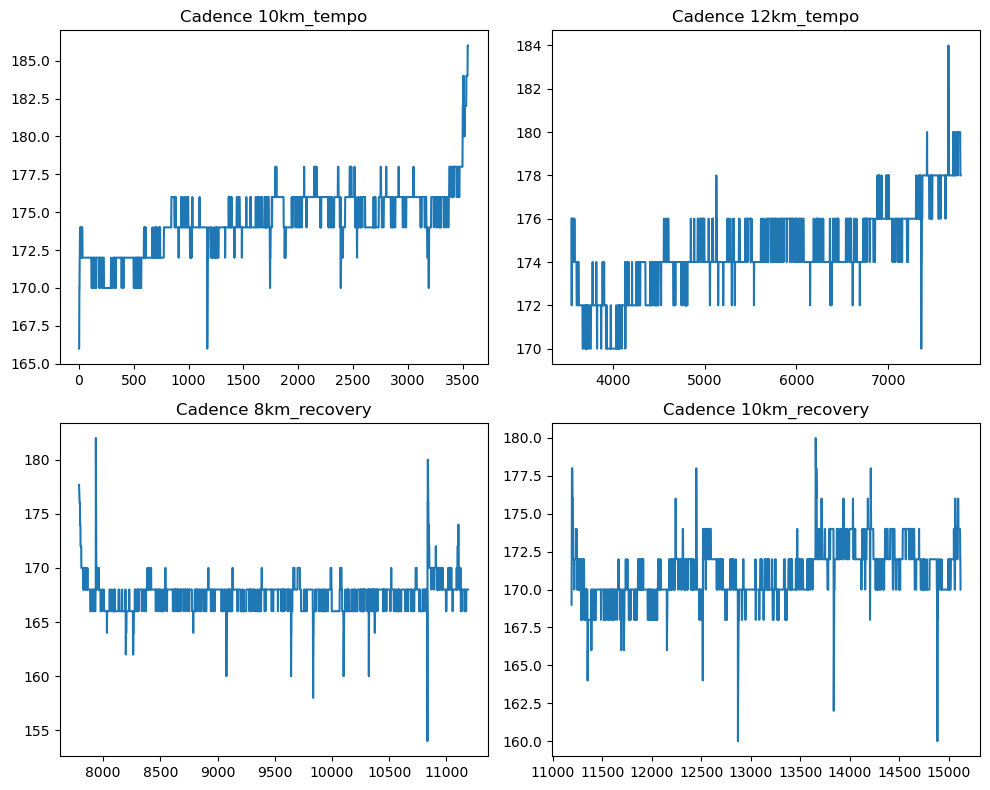

In [97]:
plot_column_per_run(data, 'Cadence')

### Speed

In [98]:
data['Speed'] = data['Speed'].interpolate(method='polynomial', order=2)

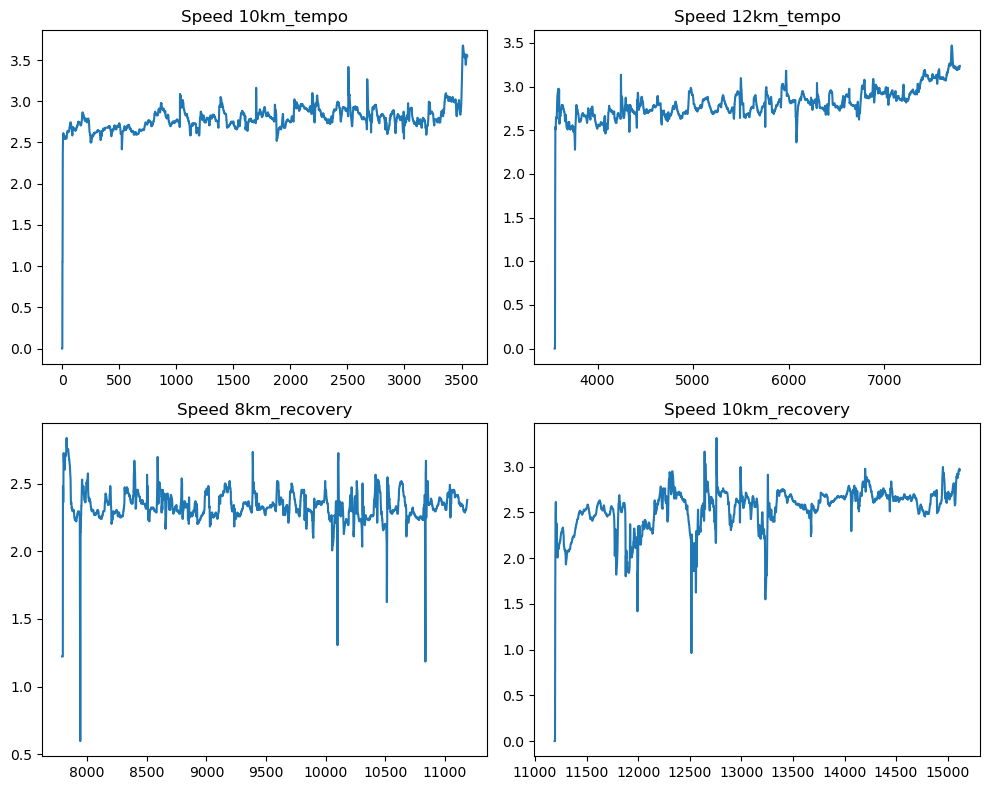

In [99]:
plot_column_per_run(data,'Speed')

### Altitude

In [100]:
data['Altitude'] = data['Altitude'].interpolate(method='polynomial', order=3)
# Forward fill remaining NaNs on a per-run basis
data['Altitude'] = data.groupby('Run')['Altitude'].fillna(method='ffill')
data['Altitude'] = data.groupby('Run')['Altitude'].fillna(method='bfill')
#data['Altitude'] = data.groupby('Run')['Altitude'].fillna(method='ffill')

In [101]:
#This step can be ommitted in case of bad prediction resutls in ML 
# Choose a window size (number of points to average over)
window_size = 30  # or any other number that seems appropriate for your data

data['Altitude'] = data.groupby('Run')['Altitude'].transform(lambda x: x.rolling(window_size, center=True).mean())
#data['Altitude'] = data['Altitude'].interpolate()
# Forward fill remaining NaNs on a per-run basis
data['Altitude'] = data.groupby('Run')['Altitude'].fillna(method='ffill')
data['Altitude'] = data.groupby('Run')['Altitude'].fillna(method='bfill')
#data['Altitude'] = data['Altitude'].fillna(method='ffill')
#data['Altitude'] = data['Altitude'].fillna(method='ffill')

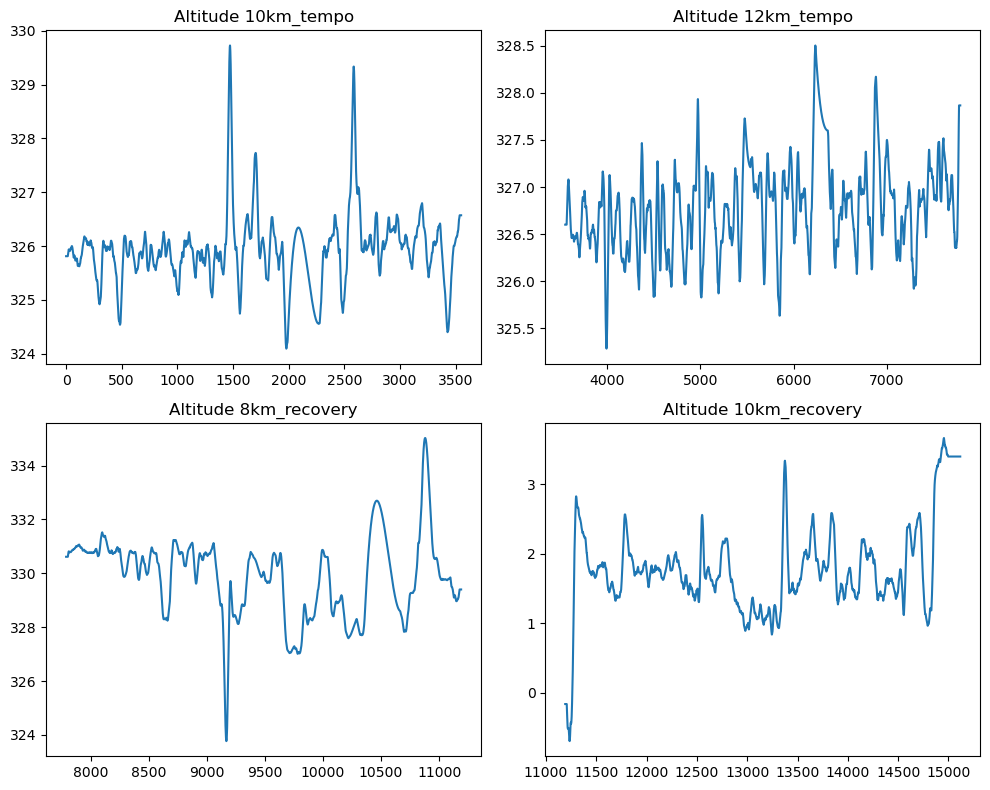

In [102]:
plot_column_per_run(data,'Altitude')

In [103]:
data['Altitude']

0        325.813336
1        325.813336
2        325.813336
3        325.813336
4        325.813336
            ...    
15113      3.400000
15114      3.400000
15115      3.400000
15116      3.400000
15117      3.400000
Name: Altitude, Length: 15118, dtype: float64

In [104]:
count_missing_values(data)

Missing values per column:
Unnamed: 0: 0
Time: 0
Distance: 0
Altitude: 0
HeartRate: 0
Speed: 0
Cadence: 0
HeartRateZone: 0
Run: 0


/var/folders/l0/924kw60548b_9q6yvy_gzsyc0000gn/T/ipykernel_8355/1562971855.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, count in missing_values.iteritems():


## Exploratory data analysis

/var/folders/l0/924kw60548b_9q6yvy_gzsyc0000gn/T/ipykernel_8355/1810984961.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


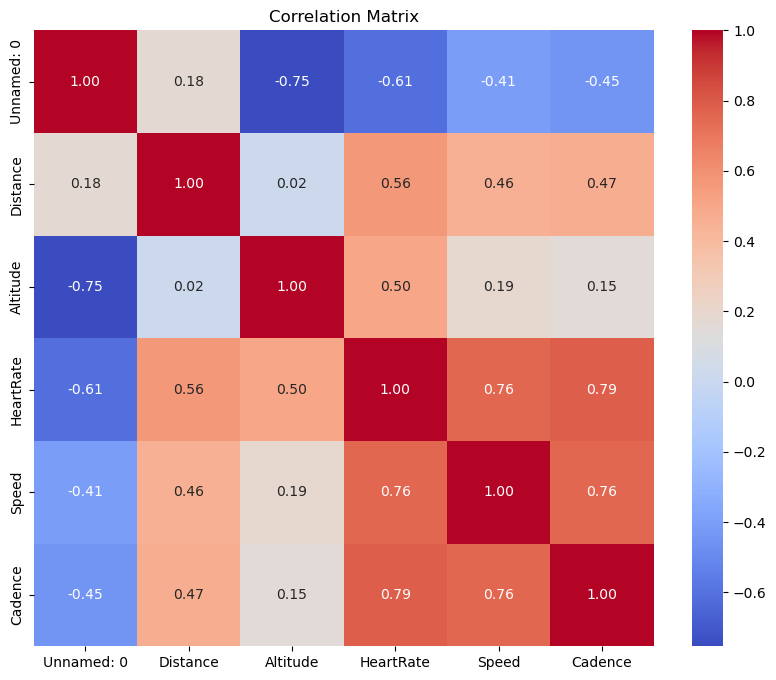

In [105]:
corr_matrix = data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

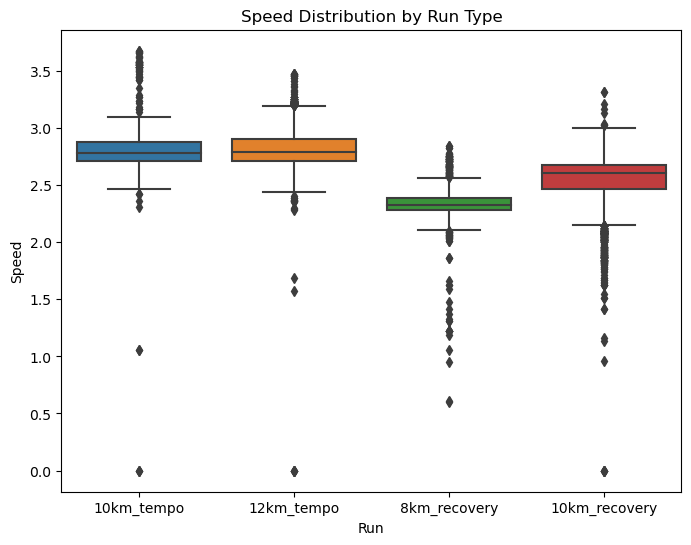

In [106]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Run', y='Speed', data=data)
plt.title('Speed Distribution by Run Type')
plt.show()

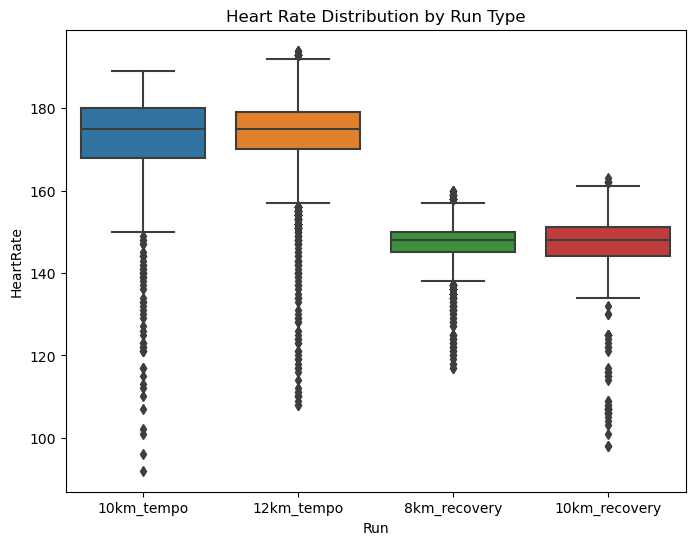

In [107]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Run', y='HeartRate', data=data)
plt.title('Heart Rate Distribution by Run Type')
plt.show()

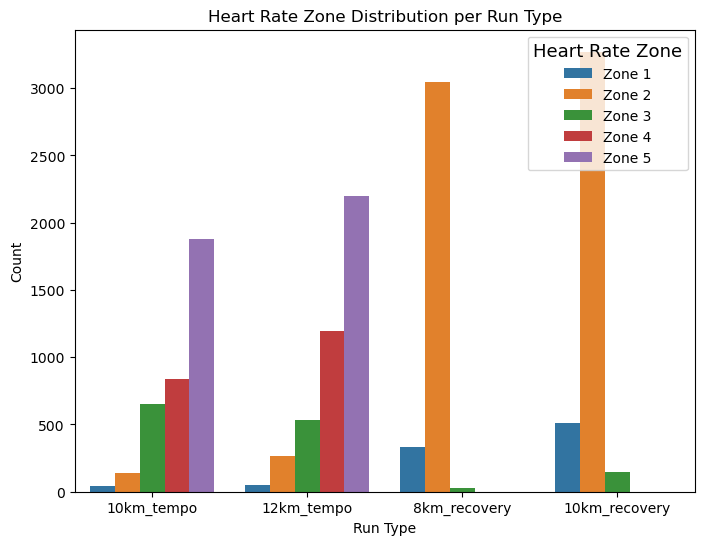

In [108]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Run', hue='HeartRateZone', data=data)
plt.title('Heart Rate Zone Distribution per Run Type')
plt.xlabel('Run Type')
plt.ylabel('Count')
plt.legend(title='Heart Rate Zone', title_fontsize='13', loc='upper right')
plt.show()

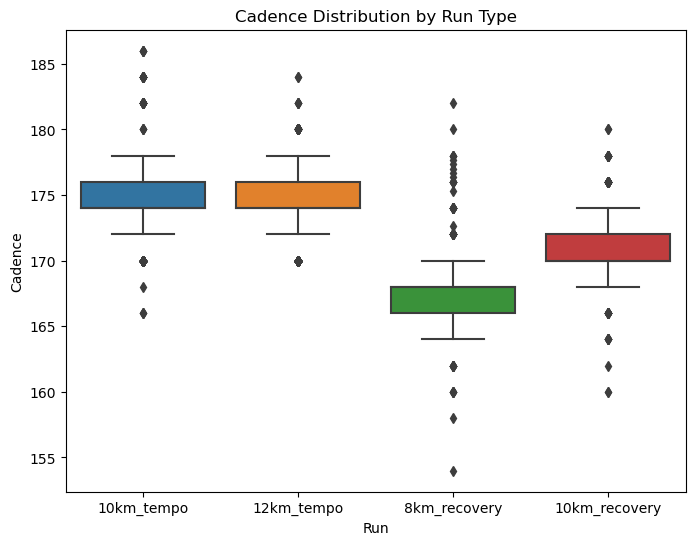

In [109]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Run', y='Cadence', data=data)
plt.title('Cadence Distribution by Run Type')
plt.show()

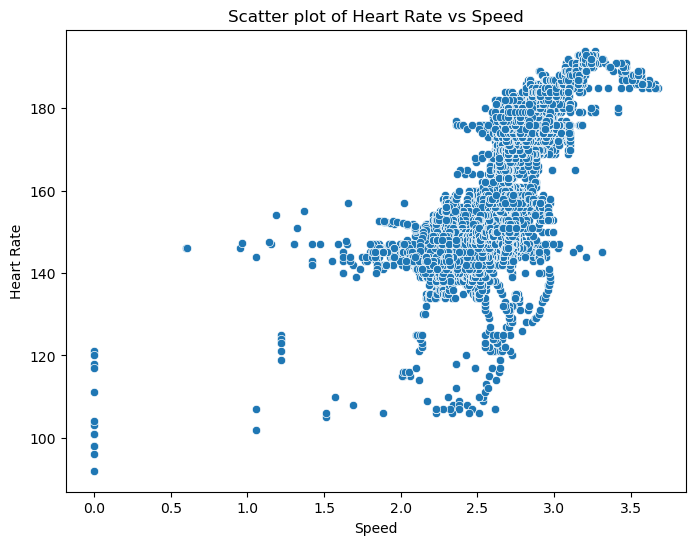

In [110]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Speed', y='HeartRate', data=data)
plt.title('Scatter plot of Heart Rate vs Speed')
plt.xlabel('Speed')
plt.ylabel('Heart Rate')
plt.show()

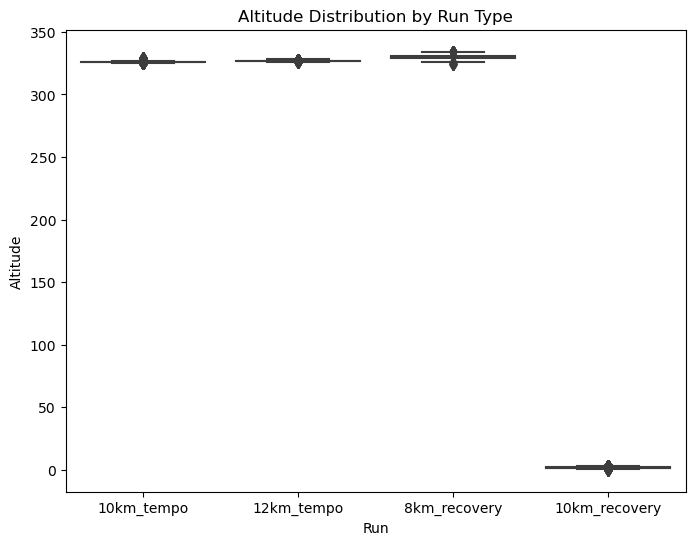

In [111]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Run', y='Altitude', data=data)
plt.title('Altitude Distribution by Run Type')
plt.show()

## Feature Engineering

### Simple features

#### Pace

In [112]:
# compute pace in seconds per meter (s/m)
data['Pace'] = np.where(data['Speed'] != 0, 1 / data['Speed'], 0)
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace
0,0,2022-07-29T05:21:40.000Z,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000
1,1,2022-07-29T05:21:41.000Z,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000
2,2,2022-07-29T05:21:42.000Z,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000
3,3,2022-07-29T05:21:43.000Z,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767
4,4,2022-07-29T05:21:44.000Z,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767
...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06T06:00:59.000Z,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021
15114,15114,2022-09-06T06:00:59.000Z,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021
15115,15115,2022-09-06T06:01:00.000Z,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021
15116,15116,2022-09-06T06:01:01.000Z,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066


#### Acceleration

In [113]:
import datetime

# Convert 'time' from ISO 8601 string format to datetime
data['Time'] = pd.to_datetime(data['Time'])

speed_diff= data['Speed'].diff()
# calculate the difference in time
time_diff = data['Time'].diff().dt.total_seconds()
# compute acceleration in m/s^2
data['Acceleration'] = speed_diff / time_diff
# Fill NaN values in 'acceleration' with zero
data['Acceleration'] = data['Acceleration'].fillna(0)
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,Acceleration
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,0.000
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,1.054
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,0.000
...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,-0.018


#### Steps per run

In [114]:
# Convert cadence from steps per minute to steps per second
data['cadence_per_second'] = data['Cadence'] / 60

# Define a label column for each run, e.g. 'run_label'
#df['run_label'] = ['10km_tempo', '5km_easy', '10km_tempo', ...]
# Calculate total steps per run and convert to DataFrame
total_steps_per_run = data.groupby('Run')['cadence_per_second'].sum().reset_index()
total_steps_per_run.columns = ['Run', 'TotalSteps']

# Merge total steps per run with the original DataFrame
data = pd.merge(data, total_steps_per_run, on='Run', how='left')
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,Acceleration,cadence_per_second,TotalSteps
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,0.000,2.833333,10322.066667
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,1.054,2.833333,10322.066667
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,0.000,2.833333,10322.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,-0.018,2.833333,11201.650000


#### Run type column 

In [115]:
runtype = data['Run'].str.split('_').str[1]
data['RunType'] = runtype
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,Acceleration,cadence_per_second,TotalSteps,RunType
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,tempo
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,tempo
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,0.000,2.833333,10322.066667,tempo
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,1.054,2.833333,10322.066667,tempo
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,0.000,2.833333,10322.066667,tempo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,-0.018,2.833333,11201.650000,recovery


#### Elevation gain

In [116]:
#data['Elevation'] = data['Altitude'] / data['Distance']
altitude_diff = data.groupby('Run')['Altitude'].diff()
data['Elevation'] = data.groupby('Run')['Altitude'].diff()
data['Elevation'] = data['Elevation'].fillna(0)
#data.loc[data['Elevation'] < 0, 'Elevation'] = 0
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,Acceleration,cadence_per_second,TotalSteps,RunType,Elevation
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,tempo,0.0
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,tempo,0.0
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,0.000,2.833333,10322.066667,tempo,0.0
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,1.054,2.833333,10322.066667,tempo,0.0
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,0.000,2.833333,10322.066667,tempo,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery,0.0
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery,0.0
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery,0.0
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,-0.018,2.833333,11201.650000,recovery,0.0


### One-hot encoding

In [117]:
# one hot encoding for runtype and heart rate zone and run

print(data['RunType'].unique())
print(data['HeartRateZone'].unique())
print(data['Run'].unique())



['tempo' 'recovery']
['Zone 1' 'Zone 2' 'Zone 3' 'Zone 4' 'Zone 5']
['10km_tempo' '12km_tempo' '8km_recovery' '10km_recovery']


In [118]:
# one hot encoding 

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

data_onehotencoding = data['RunType']
values = array(data_onehotencoding)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])

outcomes_runtype = pd.DataFrame(onehot_encoded, columns=['Recovery', 'Tempo'])
print(outcomes_runtype)

       Recovery  Tempo
0           0.0    1.0
1           0.0    1.0
2           0.0    1.0
3           0.0    1.0
4           0.0    1.0
...         ...    ...
15113       1.0    0.0
15114       1.0    0.0
15115       1.0    0.0
15116       1.0    0.0
15117       1.0    0.0

[15118 rows x 2 columns]


/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [119]:
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,Acceleration,cadence_per_second,TotalSteps,RunType,Elevation
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,tempo,0.0
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,tempo,0.0
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,0.000,2.833333,10322.066667,tempo,0.0
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,1.054,2.833333,10322.066667,tempo,0.0
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,0.000,2.833333,10322.066667,tempo,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery,0.0
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery,0.0
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery,0.0
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,-0.018,2.833333,11201.650000,recovery,0.0


In [120]:
# data_onehotencoding = data['HeartRateZone']
# values = array(data_onehotencoding)

# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(values)

# onehot_encoder = OneHotEncoder(sparse=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])

# outcomes_heartratezone = pd.DataFrame(onehot_encoded, columns=['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5'])
# print(outcomes_heartratezone)

In [121]:
data_onehotencoding = data['Run']
values = array(data_onehotencoding)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])

outcomes_run = pd.DataFrame(onehot_encoded, columns=['10km_recovery','10km_tempo','12km_tempo','8km_recovery'])
print(outcomes_run)

       10km_recovery  10km_tempo  12km_tempo  8km_recovery
0                0.0         1.0         0.0           0.0
1                0.0         1.0         0.0           0.0
2                0.0         1.0         0.0           0.0
3                0.0         1.0         0.0           0.0
4                0.0         1.0         0.0           0.0
...              ...         ...         ...           ...
15113            1.0         0.0         0.0           0.0
15114            1.0         0.0         0.0           0.0
15115            1.0         0.0         0.0           0.0
15116            1.0         0.0         0.0           0.0
15117            1.0         0.0         0.0           0.0

[15118 rows x 4 columns]


/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [122]:
data = pd.merge(data, outcomes_runtype, left_index=True, right_index=True)
# data = pd.merge(data, outcomes_heartratezone, left_index=True, right_index=True)
data = pd.merge(data, outcomes_run, left_index=True, right_index=True)

data



,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,...,cadence_per_second,TotalSteps,RunType,Elevation,Recovery,Tempo,10km_recovery,10km_tempo,12km_tempo,8km_recovery
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,...,2.766667,10322.066667,tempo,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,...,2.766667,10322.066667,tempo,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,...,2.833333,10322.066667,tempo,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,...,2.833333,10322.066667,tempo,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,...,2.833333,10322.066667,tempo,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,...,2.866667,11201.650000,recovery,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,...,2.866667,11201.650000,recovery,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,...,2.866667,11201.650000,recovery,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,...,2.833333,11201.650000,recovery,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [123]:
# subset = data[data['HeartRateZone'] == 'Zone 5']
# subset

### Advanced features

In [124]:
# time window
# how to do with overlap?
# 
# for i in range (data)
# take average over i + x after
# shift i (or more for less overlap?) (shift 1?)
# continiou unitl end

# shift with 1
# window size of 5
# take mean/min/max/avg

# take mean/min/ma/sd and add it at current point, look 5 lambda back

print(data.columns.tolist())

['Unnamed: 0', 'Time', 'Distance', 'Altitude', 'HeartRate', 'Speed', 'Cadence', 'HeartRateZone', 'Run', 'Pace', 'Acceleration', 'cadence_per_second', 'TotalSteps', 'RunType', 'Elevation', 'Recovery', 'Tempo', '10km_recovery', '10km_tempo', '12km_tempo', '8km_recovery']


#### Avg for all numerical features: time window of 5

In [125]:
# average for numerical values with a time window of 5

columns_to_process = ['Distance', 'Altitude', 'Speed', 'Cadence', 'Pace', 'Acceleration', 'cadence_per_second', 'TotalSteps', 'Elevation']

# Define the window size for the moving average calculation
window_size = 5

# Loop through the column names
for column_name in columns_to_process:
    new_column_values = []

    # Calculate the moving average for the current column
    for i in range(len(data)):
        start_index = max(0, i - window_size + 1)
        end_index = i + 1

        if end_index < window_size and start_index == 0:
            new_column_values.append(0)
        else:
            average = data[column_name][start_index:end_index].mean()
            new_column_values.append(average)

    # Pad the end of the list with NaN values
    new_column_values += [None] * (len(data) - len(new_column_values))

    # Create a new column based on the current column name
    new_column_name = f'{column_name}_average'
    data[new_column_name] = new_column_values

# Print the updated dataframe
# print(data)

#### Max for numerical features

In [126]:
# maximum for numerical values with a time window of 5

# columns_to_process = ['Distance', 'Altitude', 'HeartRate', 'Speed', 'Cadence', 'Pace', 'Acceleration', 'cadence_per_second', 'TotalSteps', 'Elevation']

# Define the window size for the moving average calculation
window_size = 5

# Loop through the column names
for column_name in columns_to_process:
    new_column_values = []

    # Calculate the moving average for the current column
    for i in range(len(data)):
        start_index = max(0, i - window_size + 1)
        end_index = i + 1

        if end_index < window_size and start_index == 0:
            new_column_values.append(0)
        else:
            average = data[column_name][start_index:end_index].max()
            new_column_values.append(average)

    # Pad the end of the list with NaN values
    new_column_values += [None] * (len(data) - len(new_column_values))

    # Create a new column based on the current column name
    new_column_name = f'{column_name}_max'
    data[new_column_name] = new_column_values

# Print the updated dataframe
# print(data)

#### Min for numerical features

In [127]:
# minimum for numerical values with a time window of 5

# columns_to_process = ['Distance', 'Altitude', 'HeartRate', 'Speed', 'Cadence', 'Pace', 'Acceleration', 'cadence_per_second', 'TotalSteps', 'Elevation']

# Define the window size for the moving average calculation
window_size = 5

# Loop through the column names
for column_name in columns_to_process:
    new_column_values = []

    # Calculate the moving average for the current column
    for i in range(len(data)):
        start_index = max(0, i - window_size + 1)
        end_index = i + 1

        if end_index < window_size and start_index == 0:
            new_column_values.append(0)
        else:
            average = data[column_name][start_index:end_index].min()
            new_column_values.append(average)

    # Pad the end of the list with NaN values
    new_column_values += [None] * (len(data) - len(new_column_values))

    # Create a new column based on the current column name
    new_column_name = f'{column_name}_min'
    data[new_column_name] = new_column_values

# Print the updated dataframe
# print(data)

#### Std for numerical features

In [128]:
# std for numerical values with a time window of 5

# columns_to_process = ['Distance', 'Altitude', 'HeartRate', 'Speed', 'Cadence', 'Pace', 'Acceleration', 'cadence_per_second', 'TotalSteps', 'Elevation']

# Define the window size for the moving average calculation
window_size = 5

# Loop through the column names
for column_name in columns_to_process:
    new_column_values = []

    # Calculate the moving average for the current column
    for i in range(len(data)):
        start_index = max(0, i - window_size + 1)
        end_index = i + 1

        if end_index < window_size and start_index == 0:
            new_column_values.append(0)
        else:
            average = data[column_name][start_index:end_index].std()
            new_column_values.append(average)

    # Pad the end of the list with NaN values
    new_column_values += [None] * (len(data) - len(new_column_values))

    # Create a new column based on the current column name
    new_column_name = f'{column_name}_std'
    data[new_column_name] = new_column_values

# Print the updated dataframe
# print(data)

In [129]:
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,...,Elevation_min,Distance_std,Altitude_std,Speed_std,Cadence_std,Pace_std,Acceleration_std,cadence_per_second_std,TotalSteps_std,Elevation_std
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,...,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,...,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,...,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,...,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,...,0.0,3.477452,0.000000e+00,0.577300,2.190890,0.519661,0.471363,0.036515,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,...,0.0,4.834329,4.965068e-16,0.009000,0.894427,0.001022,0.004930,0.014907,0.0,0.0
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,...,0.0,3.924261,4.965068e-16,0.008050,1.095445,0.000914,0.004930,0.018257,0.0,0.0
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,...,0.0,3.271523,4.965068e-16,0.004025,1.095445,0.000456,0.004930,0.018257,0.0,0.0
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,...,0.0,3.762317,4.965068e-16,0.008050,1.414214,0.000914,0.009859,0.023570,0.0,0.0


In [130]:
total_features = data.shape[1] - 1
print("Total number of features: ", total_features)

Total number of features:  56


## Classification

In [131]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

#### Random Forrest classifier

In [132]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
# Initialize the label encoder
le = LabelEncoder()

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def classify_random_forest(X_train, X_test, y_train, y_test): 
    # Train Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred= clf.predict(X_test)

    y_pred = le.inverse_transform(y_pred)
    y_test = le.inverse_transform(y_test)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Print metrics
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n {confusion}')
    print(f'Classification Report:\n {report}')


### Feature selection

In [133]:
correlations = data.corrwith(data['HeartRate']).sort_values(ascending=False)
print(correlations)

HeartRate                     1.000000
Tempo                         0.839582
Cadence                       0.786858
cadence_per_second            0.786858
Speed_average                 0.770986
Speed_max                     0.758655
Speed                         0.757544
Speed_min                     0.752919
cadence_per_second_min        0.655134
Cadence_min                   0.655134
cadence_per_second_average    0.652017
Cadence_average               0.652017
Cadence_max                   0.636288
cadence_per_second_max        0.636288
Distance                      0.562655
Distance_min                  0.562472
Distance_average              0.559175
Distance_max                  0.554893
12km_tempo                    0.523444
Altitude_min                  0.506346
Altitude_average              0.505267
Altitude_max                  0.504081
Altitude                      0.504026
10km_tempo                    0.435185
TotalSteps_min                0.420710
TotalSteps_average       

/var/folders/l0/924kw60548b_9q6yvy_gzsyc0000gn/T/ipykernel_8355/1749254305.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corrwith(data['HeartRate']).sort_values(ascending=False)


In [134]:
# Get counts of each heart rate zone
counts = data['HeartRateZone'].value_counts()

# Print the counts
print(counts)

Zone 2    6720
Zone 5    4081
Zone 4    2035
Zone 3    1357
Zone 1     925
Name: HeartRateZone, dtype: int64


Oopsi, we are dealing with a bit imbalanced dataset 

In [135]:
# Calculate the number of seconds from the start of each run
data['Time'] = data.groupby('Run')['Time'].transform(lambda x: (x - x.min()).dt.total_seconds())

In [136]:
#dropping categorical data that is one-hot encoded
data_init = data.copy()
data_init = data_init.drop(columns =['RunType', 'HeartRate','Unnamed: 0'])
data = data.drop(columns =['RunType', 'HeartRate', 'Run','Unnamed: 0'])
data

,Time,Distance,Altitude,Speed,Cadence,HeartRateZone,Pace,Acceleration,cadence_per_second,TotalSteps,...,Elevation_min,Distance_std,Altitude_std,Speed_std,Cadence_std,Pace_std,Acceleration_std,cadence_per_second_std,TotalSteps_std,Elevation_std
0,0.0,1.200000,325.813336,0.000,166.0,Zone 1,0.000000,0.000,2.766667,10322.066667,...,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1.0,3.670000,325.813336,0.000,166.0,Zone 1,0.000000,0.000,2.766667,10322.066667,...,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,2.0,6.070000,325.813336,0.000,170.0,Zone 1,0.000000,0.000,2.833333,10322.066667,...,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,3.0,7.870000,325.813336,1.054,170.0,Zone 1,0.948767,1.054,2.833333,10322.066667,...,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,4.0,10.080000,325.813336,1.054,170.0,Zone 1,0.948767,0.000,2.833333,10322.066667,...,0.0,3.477452,0.000000e+00,0.577300,2.190890,0.519661,0.471363,0.036515,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,3983.0,10003.740234,3.400000,2.976,172.0,Zone 2,0.336021,0.000,2.866667,11201.650000,...,0.0,4.834329,4.965068e-16,0.009000,0.894427,0.001022,0.004930,0.014907,0.0,0.0
15114,3983.0,10003.740234,3.400000,2.976,172.0,Zone 2,0.336021,0.000,2.866667,11201.650000,...,0.0,3.924261,4.965068e-16,0.008050,1.095445,0.000914,0.004930,0.018257,0.0,0.0
15115,3984.0,10006.309570,3.400000,2.976,172.0,Zone 2,0.336021,0.000,2.866667,11201.650000,...,0.0,3.271523,4.965068e-16,0.004025,1.095445,0.000456,0.004930,0.018257,0.0,0.0
15116,3985.0,10010.650391,3.400000,2.958,170.0,Zone 2,0.338066,-0.018,2.833333,11201.650000,...,0.0,3.762317,4.965068e-16,0.008050,1.414214,0.000914,0.009859,0.023570,0.0,0.0


#### Forward feature selection

In [137]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import copy

def forward_selection(max_features, X_train, X_test, y_train, y_test):
    # Start with no features.
    ordered_features = []
    ordered_scores = []
    selected_features = []

    prev_best_perf = 0

    # Select the appropriate number of features.
    for i in range(0, max_features):
        # Determine the features left to select.
        features_left = list(set(X_train.columns) - set(selected_features))
        best_perf = 0
        best_attribute = ''

        print("Added feature{}".format(i))
        # For all features we can still select...
        for f in features_left:
            temp_selected_features = copy.deepcopy(selected_features)
            temp_selected_features.append(f)

            # Initialize the Random Forest Classifier
            clf = RandomForestClassifier(n_estimators=100, random_state=42)

            # Train the classifier
            clf.fit(X_train[temp_selected_features], y_train)

            # Make predictions on the test set
            pred_y_test = clf.predict(X_test[temp_selected_features])

            # Calculate the accuracy of the predictions
            perf = accuracy_score(y_test, pred_y_test)

            # If the performance is better than what we have seen so far (we aim for high accuracy)
            # we set the current feature to the best feature and the same for the best performance.
            if perf > best_perf:
                best_perf = perf
                best_feature = f

        # We select the feature with the best performance.
        selected_features.append(best_feature)
        prev_best_perf = best_perf
        ordered_features.append(best_feature)
        ordered_scores.append(best_perf)

    return selected_features, ordered_features, ordered_scores


In [138]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=['HeartRateZone'])
y = data['HeartRateZone']
# Fit the forward feature selector to the training data
# Split your data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#sfs = sfs.fit(X_train, y_train)

selected_features, ordered_features, ordered_scores = forward_selection(10, X_train, X_test, y_train, y_test)

print("Selected features: ", selected_features)
print("Ordered features: ", ordered_features)
print("Ordered scores: ", ordered_scores)

Added feature0
Added feature1
Added feature2
Added feature3
Added feature4
Added feature5
Added feature6
Added feature7
Added feature8
Added feature9
Selected features:  ['cadence_per_second_average', 'Time', 'TotalSteps_min', 'Distance_min', 'Recovery', 'Altitude', 'Distance', '10km_recovery', 'Acceleration_min', '12km_tempo']
Ordered features:  ['cadence_per_second_average', 'Time', 'TotalSteps_min', 'Distance_min', 'Recovery', 'Altitude', 'Distance', '10km_recovery', 'Acceleration_min', '12km_tempo']
Ordered scores:  [0.7208994708994709, 0.9041005291005291, 0.9629629629629629, 0.9673721340388007, 0.9682539682539683, 0.968694885361552, 0.9680335097001763, 0.9680335097001763, 0.9678130511463845, 0.9673721340388007]


In [139]:
selected_features.append('10km_tempo')
selected_features.append('8km_recovery')

### Classifying zones for one specific run

In [140]:
#Separate features and target
X = data.drop(columns=['HeartRateZone'])
y = data['HeartRateZone']

from sklearn.preprocessing import LabelEncoder
# Initialize the label encoder
le = LabelEncoder()
# Fit and transform the 'HeartRateZone' column
y = le.fit_transform(y)

# For precicting recovery run
X_train_recovery = X[(X['10km_tempo'] == 1) | (X['12km_tempo'] == 1) | (X['8km_recovery'] == 1)]
y_train_recovery = y[(X['10km_tempo'] == 1) | (X['12km_tempo'] == 1) | (X['8km_recovery'] == 1)]

X_test_recovery = X[X['10km_recovery'] == 1]
y_test_recovery = y[X['10km_recovery'] == 1]

# For precicting  tempo run
X_train_tempo = X[(X['10km_recovery'] == 1) | (X['12km_tempo'] == 1) | (X['8km_recovery'] == 1)]
y_train_tempo = y[(X['10km_recovery'] == 1) | (X['12km_tempo'] == 1) | (X['8km_recovery'] == 1)]

X_test_tempo = X[X['10km_tempo'] == 1]
y_test_tempo = y[X['10km_tempo'] == 1]

# X_train =  X_train.drop(columns=['10km_recovery', '12km_tempo', '8km_recovery', '10km_tempo'])
# X_test  =  X_test.drop(columns=['10km_recovery', '12km_tempo', '8km_recovery','10km_tempo'])


selected_features_tempo, ordered_features_tempo, ordered_scores_tempo = forward_selection(10, X_train_tempo, X_test_tempo, y_train_tempo, y_test_tempo)
selected_features_recovery, ordered_features_recovery, ordered_scores_recovery = forward_selection(10, X_train_recovery, X_test_recovery, y_train_recovery, y_test_recovery)

Added feature0
Added feature1
Added feature2
Added feature3
Added feature4
Added feature5
Added feature6
Added feature7
Added feature8
Added feature9
Added feature0
Added feature1
Added feature2
Added feature3
Added feature4
Added feature5
Added feature6
Added feature7
Added feature8
Added feature9


In [141]:
selected_features_recovery

['12km_tempo',
 'TotalSteps_std',
 'Altitude',
 'Elevation_average',
 'Altitude_average',
 'Cadence_std',
 '10km_recovery',
 'Recovery',
 'TotalSteps_average',
 'Pace_std']

In [142]:
selected_features_tempo

['Cadence_max',
 'Recovery',
 'Distance_min',
 'Pace_average',
 'cadence_per_second_min',
 'Altitude_max',
 'Speed_std',
 'Altitude_average',
 'Tempo',
 'cadence_per_second_average']

In [143]:
print("Recovery run:")
classify_random_forest(X_train_recovery[selected_features_recovery], X_test_recovery[selected_features_recovery], y_train_recovery, y_test_recovery)

Recovery run:
Accuracy: 0.6634419551934827
Confusion Matrix:
 [[   9  415    0   86]
 [   0 2597    0  675]
 [   0  119    0   27]
 [   0    0    0    0]]
Classification Report:
               precision    recall  f1-score   support

      Zone 1       1.00      0.02      0.03       510
      Zone 2       0.83      0.79      0.81      3272
      Zone 3       0.00      0.00      0.00       146
      Zone 5       0.00      0.00      0.00         0

    accuracy                           0.66      3928
   macro avg       0.46      0.20      0.21      3928
weighted avg       0.82      0.66      0.68      3928



/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nasti

In [144]:
print("Tempo run:")
classify_random_forest(X_train_tempo[selected_features_tempo], X_test_tempo[selected_features_tempo], y_train_tempo, y_test_tempo)

Tempo run:
Accuracy: 0.8879188960856097
Confusion Matrix:
 [[   0   30    9    0    0]
 [   0  105   33    0    0]
 [   0   54  552   46    0]
 [   0    0   15  807   18]
 [   0    0    0  193 1689]]
Classification Report:
               precision    recall  f1-score   support

      Zone 1       0.00      0.00      0.00        39
      Zone 2       0.56      0.76      0.64       138
      Zone 3       0.91      0.85      0.88       652
      Zone 4       0.77      0.96      0.86       840
      Zone 5       0.99      0.90      0.94      1882

    accuracy                           0.89      3551
   macro avg       0.64      0.69      0.66      3551
weighted avg       0.89      0.89      0.89      3551



/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Generalized data spliting per each run (70% - training, 30% - test per run)

In [255]:
def split_data(data, test_size=0.3):
    runs = data['Run'].unique()
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for run in runs:
        run_data = data[data['Run'] == run]
        train_run = run_data.sample(frac=1-test_size, random_state=42)
        test_run = run_data.drop(train_run.index)
        
        train_data = pd.concat([train_data, train_run])
        test_data = pd.concat([test_data, test_run])
        
    return train_data, test_data

# Use the function to split your data
train_data, test_data = split_data(data_init)


#X_train = train_data[selected_features]
y_train = train_data['HeartRateZone']
#X_test = test_data[selected_features]
y_test = test_data['HeartRateZone']
# Now you can separate the features and the target variable
train_data = train_data.drop(columns=['Run', 'HeartRateZone'], axis=1)
test_data = test_data.drop(columns=['Run', 'HeartRateZone'], axis=1)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [258]:
selected_features_gen, ordered_features_gen, ordered_scores_gen = forward_selection(10, train_data, test_data, y_train, y_test)
print(selected_features_gen)
X_train = train_data[selected_features_gen]
X_test = test_data[selected_features_gen]
# # Fit and transform the 'HeartRateZone' column
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)

In [146]:
classify_random_forest(X_train, X_test, y_train, y_test)

Accuracy: 0.964711071901191
Confusion Matrix:
 [[ 256   18    0    0    0]
 [  25 1995   10    0    0]
 [   0   21  366   11    0]
 [   0    0    5  550   37]
 [   0    0    0   33 1207]]
Classification Report:
               precision    recall  f1-score   support

      Zone 1       0.91      0.93      0.92       274
      Zone 2       0.98      0.98      0.98      2030
      Zone 3       0.96      0.92      0.94       398
      Zone 4       0.93      0.93      0.93       592
      Zone 5       0.97      0.97      0.97      1240

    accuracy                           0.96      4534
   macro avg       0.95      0.95      0.95      4534
weighted avg       0.96      0.96      0.96      4534



### Randomly splitting the dataset

In [233]:
from sklearn.model_selection import train_test_split
# Split your data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)
classify_random_forest(X_train, X_test, y_train, y_test)

Accuracy: 0.9666005291005291
Confusion Matrix:
 [[ 163   17    0    0    0]
 [   9 1368   10    0    0]
 [   0   15  256    8    0]
 [   0    0    1  357   18]
 [   0    0    0   23  779]]
Classification Report:
               precision    recall  f1-score   support

      Zone 1       0.95      0.91      0.93       180
      Zone 2       0.98      0.99      0.98      1387
      Zone 3       0.96      0.92      0.94       279
      Zone 4       0.92      0.95      0.93       376
      Zone 5       0.98      0.97      0.97       802

    accuracy                           0.97      3024
   macro avg       0.96      0.95      0.95      3024
weighted avg       0.97      0.97      0.97      3024



## Deep Learning: LSTM 

#### Important! 
Before running this code, run the following commands and restart the kernel: 
- pip install keras
- pip install tensorflow

In [290]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

df_x = data[selected_features]  
df_y = data['HeartRateZone'] 

encoder = LabelEncoder()
encoder.fit(df_y)
encoded_Y = encoder.transform(df_y)

# convert integers to dummy variables (i.e. one hot encoded)
y_encoded = np_utils.to_categorical(encoded_Y)

#scale data
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_x)

In [291]:
# First split into training (70%) and temporary (30%) datasets
x_train, x_temp, y_train, y_temp = train_test_split(df_x_scaled, y_encoded, test_size=0.3, random_state=42)

# Then split temporary dataset into validation and test datasets (15% each of total data)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

2023-06-21 15:51:41.840791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 15:51:41.843747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 15:51:41.845594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-06-21 15:51:42.065505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 15:51:42.066894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 15:51:42.068296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

528/530 [============================>.] - ETA: 0s - loss: 0.5454 - accuracy: 0.8156

2023-06-21 15:51:49.385050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 15:51:49.386713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 15:51:49.387987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

530/530 [==============================] - 8s 5ms/step - loss: 0.5447 - accuracy: 0.8159 - val_loss: 0.3501 - val_accuracy: 0.8629
Epoch 2/100
530/530 [==============================] - 2s 4ms/step - loss: 0.3323 - accuracy: 0.8714 - val_loss: 0.3341 - val_accuracy: 0.8633
Epoch 3/100
530/530 [==============================] - 2s 3ms/step - loss: 0.3178 - accuracy: 0.8815 - val_loss: 0.3250 - val_accuracy: 0.8787
Epoch 4/100
530/530 [==============================] - 2s 3ms/step - loss: 0.3164 - accuracy: 0.8756 - val_loss: 0.3135 - val_accuracy: 0.8823
Epoch 5/100
530/530 [==============================] - 2s 4ms/step - loss: 0.3108 - accuracy: 0.8797 - val_loss: 0.3157 - val_accuracy: 0.8810
Epoch 6/100
530/530 [==============================] - 2s 3ms/step - loss: 0.3087 - accuracy: 0.8802 - val_loss: 0.3085 - val_accuracy: 0.8765
Epoch 7/100
530/530 [==============================] - 2s 3ms/step - loss: 0.3066 - accuracy: 0.8826 - val_loss: 0.3191 - val_accuracy: 0.8770
Epoch 8/100

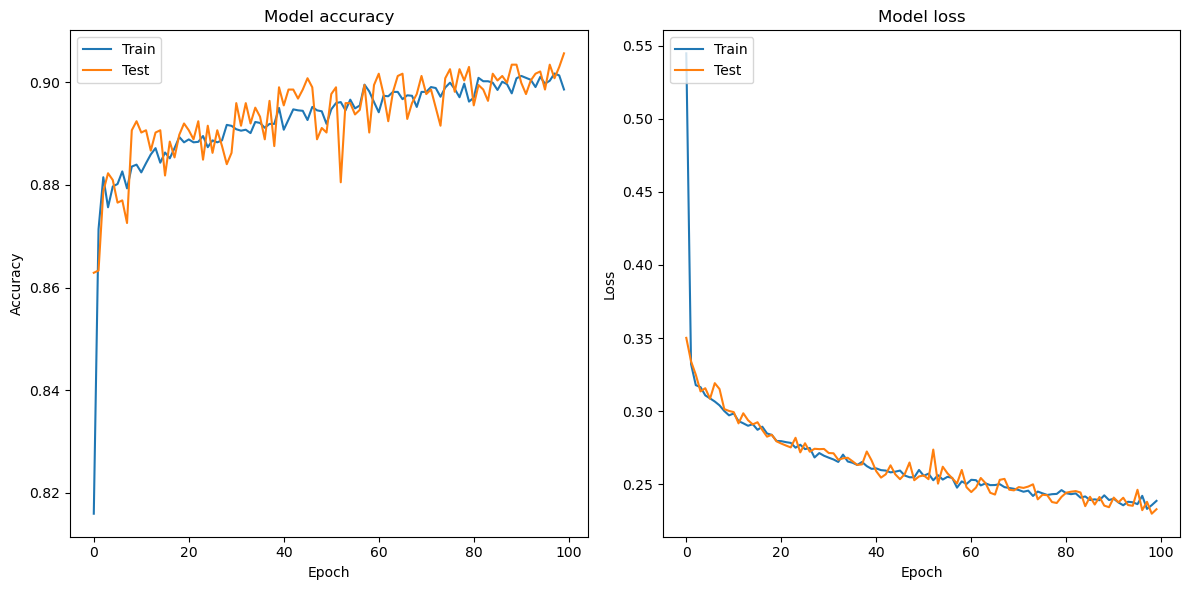

In [292]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# Adjusting the model for classification
model = Sequential()

model.add(LSTM(units=70, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=70, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=y_encoded.shape[1], activation='softmax'))  # number of classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(x_train, y_train, epochs=100, batch_size=20, validation_data=(x_val, y_val))

# Evaluating the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

### 70/30 Run Split

In [293]:
def split_data_lstm(data):
    df_x = data[selected_features_gen]  # replace with your actual features
    df_y = data['HeartRateZone']  # replace with your actual target variable
    runs = data['Run'].unique()  # get the unique run labels

    # Encode target variable
    encoder = LabelEncoder()
    encoder.fit(df_y)
    encoded_Y = encoder.transform(df_y)
    dummy_y = np_utils.to_categorical(encoded_Y)

    # Initialize the StandardScaler
    scaler = StandardScaler()

    x_train = pd.DataFrame()
    y_train = pd.DataFrame()
    x_test_val = pd.DataFrame()
    y_test_val = pd.DataFrame()

    for run in runs:
        mask = data['Run'] == run
        x_run = df_x[mask]
        y_run = dummy_y[mask]  # Use the encoded target
        
        # Scale the features
        x_run = scaler.fit_transform(x_run)
        
        train_size = int(0.7 * len(x_run))
        
        x_train_run = x_run[:train_size]
        y_train_run = y_run[:train_size]
        x_test_val_run = x_run[train_size:]
        y_test_val_run = y_run[train_size:]
        
        x_train = pd.concat([x_train, pd.DataFrame(x_train_run)])
        y_train = pd.concat([y_train, pd.DataFrame(y_train_run)])
        x_test_val = pd.concat([x_test_val, pd.DataFrame(x_test_val_run)])
        y_test_val = pd.concat([y_test_val, pd.DataFrame(y_test_val_run)])

    # Now split your test and validation data into two equal parts
    x_val, x_test, y_val, y_test = train_test_split(x_test_val.values, y_test_val.values, test_size=0.5, random_state=42)
    # Reshape data for LSTM
    x_train = x_train.values.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    
    return x_train, x_test, x_val, y_train, y_test, y_val

In [294]:
x_train, x_test, x_val, y_train, y_test, y_val = split_data_lstm(data_init)


2023-06-21 15:54:34.204527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 15:54:34.205482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 15:54:34.206917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-06-21 15:54:34.644675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 15:54:34.645916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 15:54:34.648291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

464/481 [===========================>..] - ETA: 0s - loss: 1.1909 - accuracy: 0.4752

2023-06-21 15:54:38.916231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 15:54:38.918112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 15:54:38.919392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

481/481 [==============================] - 5s 4ms/step - loss: 1.1844 - accuracy: 0.4774 - val_loss: 1.0502 - val_accuracy: 0.4751
Epoch 2/100
481/481 [==============================] - 1s 3ms/step - loss: 0.9292 - accuracy: 0.5860 - val_loss: 1.1096 - val_accuracy: 0.5315
Epoch 3/100
481/481 [==============================] - 1s 3ms/step - loss: 0.8465 - accuracy: 0.6387 - val_loss: 1.1577 - val_accuracy: 0.5253
Epoch 4/100
481/481 [==============================] - 1s 3ms/step - loss: 0.7755 - accuracy: 0.6842 - val_loss: 1.0898 - val_accuracy: 0.5721
Epoch 5/100
481/481 [==============================] - 1s 3ms/step - loss: 0.7115 - accuracy: 0.7070 - val_loss: 1.0536 - val_accuracy: 0.5892
Epoch 6/100
481/481 [==============================] - 1s 3ms/step - loss: 0.6645 - accuracy: 0.7246 - val_loss: 1.0755 - val_accuracy: 0.6747
Epoch 7/100
481/481 [==============================] - 1s 3ms/step - loss: 0.6334 - accuracy: 0.7410 - val_loss: 1.1160 - val_accuracy: 0.6853
Epoch 8/100

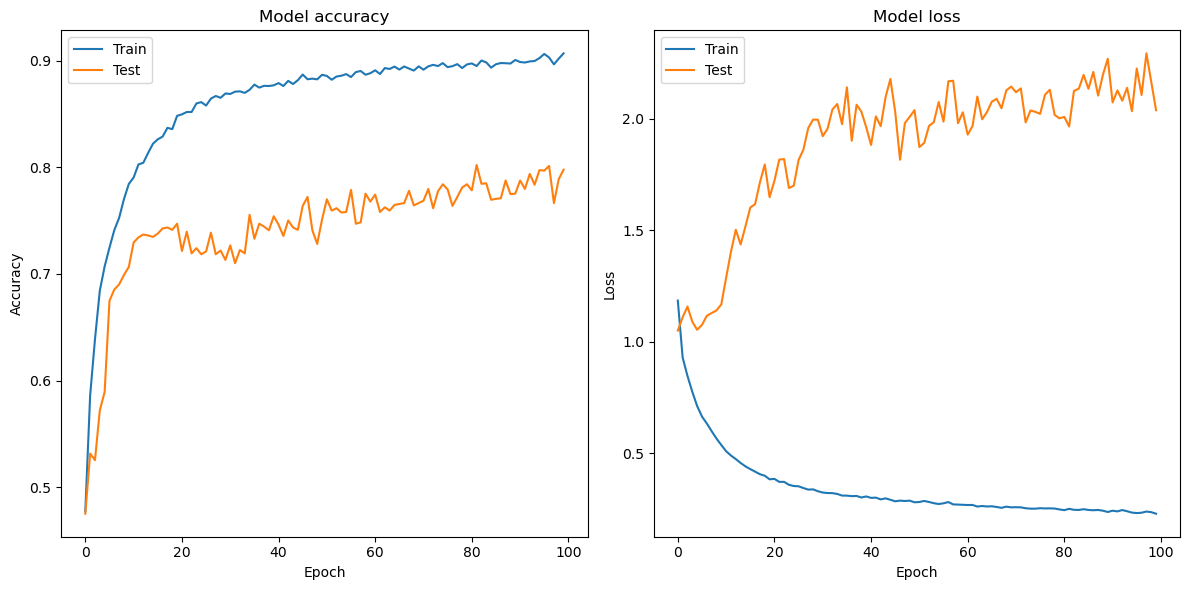

In [295]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# create the LSTM model
model = Sequential()

model.add(LSTM(70, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(70, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1], activation='softmax'))  # number of classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=22, validation_data=(x_val, y_val))

# evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

### Run Prediction

#### Recovery

In [318]:
scaler = StandardScaler()

# Note: fit_transform on train data and only transform on test data to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train_recovery)
X_test_scaled = scaler.transform(X_test_recovery)

# Concatenate the target variable of training and testing sets
y_all = np.concatenate([y_train_recovery, y_test_recovery])

# Fit the LabelEncoder and transform the target variables
encoder = LabelEncoder()
encoder.fit(y_all)
encoded_Y_all = encoder.transform(y_all)

# Convert integers to one hot encoding
dummy_y_all = np_utils.to_categorical(encoded_Y_all)

# Now split your target variable back into training and testing sets
Y_train_encoded = dummy_y_all[:len(y_train_recovery)]
Y_test_encoded = dummy_y_all[len(y_train_recovery):]
# 2. One-hot encode the target variable
# encoder = LabelEncoder()
# encoder.fit(y_train_recovery)
# encoded_Y_train = encoder.transform(y_train_recovery)
# encoded_Y_test = encoder.transform(y_test_recovery)

# Convert integers to one hot encoding
# Y_train_encoded = np_utils.to_categorical(y_train_recovery)
# Y_test_encoded = np_utils.to_categorical(y_test_recovery)

In [319]:
Y_test_encoded

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [320]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test_scaled, Y_test_encoded, test_size=0.5, random_state=42)
# Reshape input to be 3D [samples, timesteps, features] as required for LSTM
X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

2023-06-21 16:26:11.846641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 16:26:11.849099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 16:26:11.850264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-06-21 16:26:12.070794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 16:26:12.073298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 16:26:12.075320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

544/560 [============================>.] - ETA: 0s - loss: 0.5382 - accuracy: 0.8196

2023-06-21 16:26:17.648663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 16:26:17.650656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 16:26:17.652603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

560/560 [==============================] - 6s 4ms/step - loss: 0.5335 - accuracy: 0.8202 - val_loss: 8.4963 - val_accuracy: 0.0000e+00
Epoch 2/100
560/560 [==============================] - 2s 3ms/step - loss: 0.3207 - accuracy: 0.8774 - val_loss: 10.9832 - val_accuracy: 0.0000e+00
Epoch 3/100
560/560 [==============================] - 2s 3ms/step - loss: 0.2899 - accuracy: 0.8890 - val_loss: 11.2752 - val_accuracy: 0.0000e+00
Epoch 4/100
560/560 [==============================] - 2s 3ms/step - loss: 0.2706 - accuracy: 0.8969 - val_loss: 12.2107 - val_accuracy: 0.0000e+00
Epoch 5/100
560/560 [==============================] - 2s 3ms/step - loss: 0.2641 - accuracy: 0.8994 - val_loss: 12.3249 - val_accuracy: 0.0000e+00
Epoch 6/100
560/560 [==============================] - 2s 3ms/step - loss: 0.2549 - accuracy: 0.9041 - val_loss: 12.0877 - val_accuracy: 0.0000e+00
Epoch 7/100
560/560 [==============================] - 2s 3ms/step - loss: 0.2454 - accuracy: 0.9052 - val_loss: 12.9261 - va

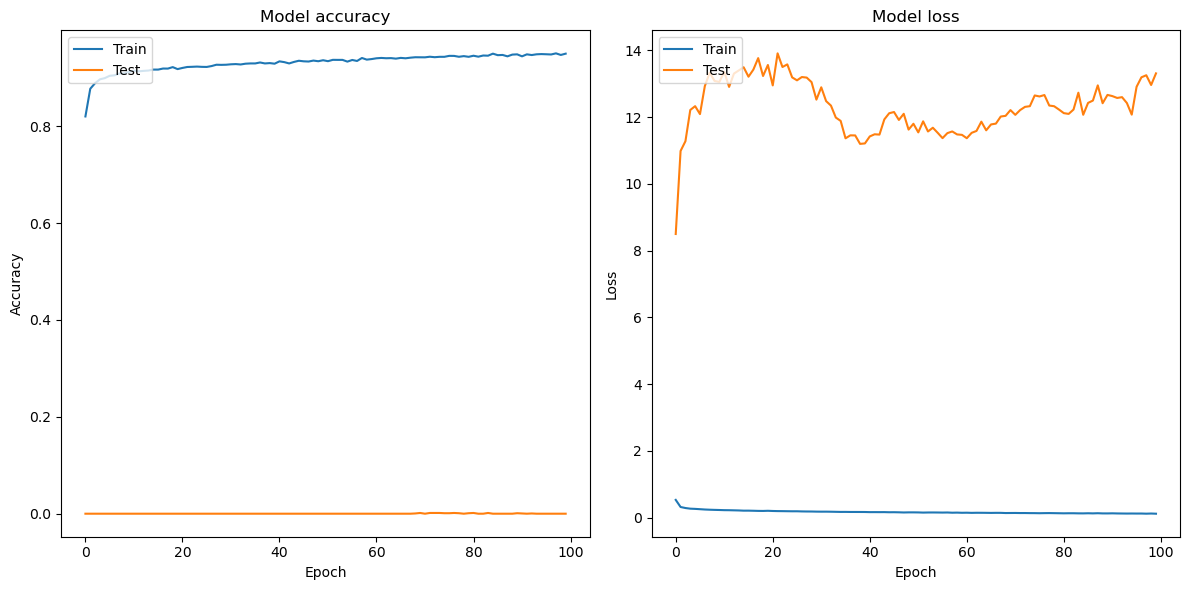

In [322]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# Create the LSTM model
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(Y_train_encoded.shape[1], activation='softmax'))  # Number of classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train_encoded, epochs=100, batch_size=20, validation_data=(X_val, Y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

### Tempo

In [323]:
scaler = StandardScaler()

# Note: fit_transform on train data and only transform on test data to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train_tempo)
X_test_scaled = scaler.transform(X_test_tempo)

# Concatenate the target variable of training and testing sets
y_all = np.concatenate([y_train_tempo, y_test_tempo])

# Fit the LabelEncoder and transform the target variables
encoder = LabelEncoder()
encoder.fit(y_all)
encoded_Y_all = encoder.transform(y_all)

# Convert integers to one hot encoding
dummy_y_all = np_utils.to_categorical(encoded_Y_all)

# Now split your target variable back into training and testing sets
Y_train_encoded = dummy_y_all[:len(y_train_tempo)]
Y_test_encoded = dummy_y_all[len(y_train_tempo):]

In [324]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test_scaled, Y_test_encoded, test_size=0.5, random_state=42)
# Reshape input to be 3D [samples, timesteps, features] as required for LSTM
X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

2023-06-21 16:36:58.399248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 16:36:58.400666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 16:36:58.402316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-06-21 16:36:58.601616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 16:36:58.603474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 16:36:58.605490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

567/579 [============================>.] - ETA: 0s - loss: 0.7673 - accuracy: 0.7527

2023-06-21 16:37:03.764263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 16:37:03.765430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 16:37:03.766912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

579/579 [==============================] - 6s 4ms/step - loss: 0.7632 - accuracy: 0.7535 - val_loss: 0.5877 - val_accuracy: 0.7932
Epoch 2/100
579/579 [==============================] - 2s 3ms/step - loss: 0.5090 - accuracy: 0.8178 - val_loss: 0.5448 - val_accuracy: 0.7623
Epoch 3/100
579/579 [==============================] - 2s 3ms/step - loss: 0.4529 - accuracy: 0.8309 - val_loss: 0.5449 - val_accuracy: 0.7538
Epoch 4/100
579/579 [==============================] - 2s 3ms/step - loss: 0.4409 - accuracy: 0.8283 - val_loss: 0.5932 - val_accuracy: 0.7425
Epoch 5/100
579/579 [==============================] - 2s 3ms/step - loss: 0.4271 - accuracy: 0.8345 - val_loss: 0.6671 - val_accuracy: 0.7324
Epoch 6/100
579/579 [==============================] - 2s 3ms/step - loss: 0.4052 - accuracy: 0.8395 - val_loss: 0.6379 - val_accuracy: 0.7392
Epoch 7/100
579/579 [==============================] - 2s 3ms/step - loss: 0.4066 - accuracy: 0.8425 - val_loss: 0.7202 - val_accuracy: 0.7352
Epoch 8/100

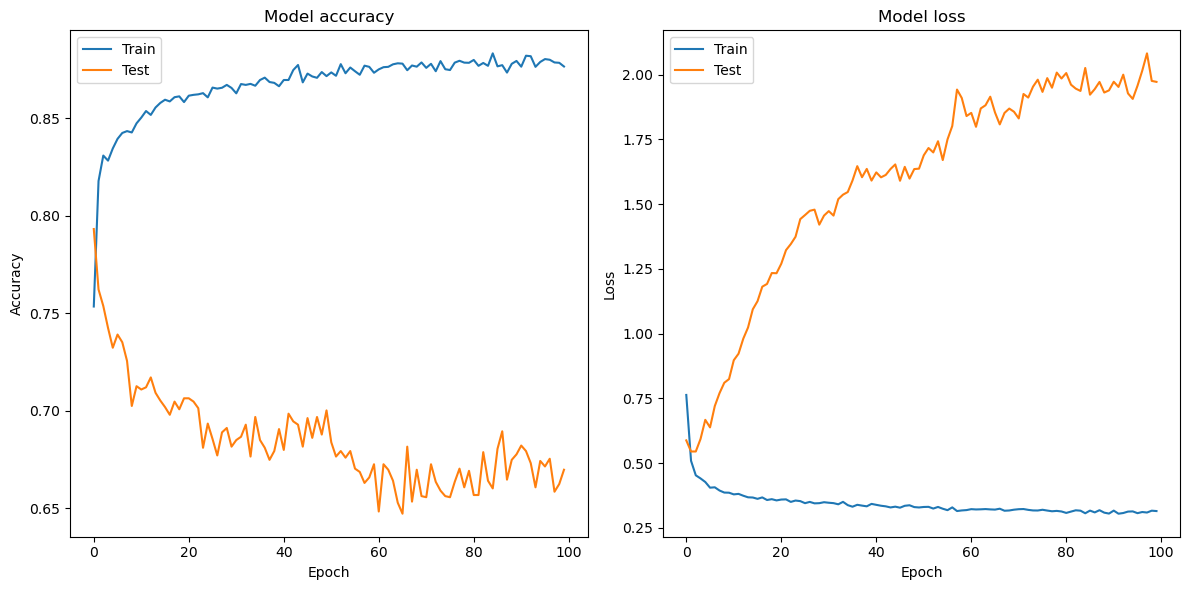

In [326]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# Create the LSTM model
model = Sequential()

model.add(LSTM(70, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.8))

model.add(LSTM(70, return_sequences=False))
model.add(Dropout(0.8))

model.add(Dense(Y_train_encoded.shape[1], activation='softmax'))  # Number of classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train_encoded, epochs=100, batch_size=20, validation_data=(X_val, Y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()